In [18]:
import kagglehub
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [19]:
def fetch_data(file_directory = 'shivam2503/diamonds', file_name = 'diamonds.csv'):
    path = kagglehub.dataset_download(file_directory)
    df = pd.read_csv(path + '/' + file_name).dropna()
    df = df.sample(frac = 1).reset_index(drop = True)
    return df[~((df['x'] <= 0) | (df['y'] <= 0) | (df['z'] <= 0) | (df['price'] <= 0))]

def prepare_data(df: pd.DataFrame, scaler: StandardScaler):
    cut_order = ["Fair", "Good", "Very Good", "Premium", "Ideal"]
    color_order = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
    clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
    cut_encoder = OrdinalEncoder(categories=[cut_order])
    color_encoder = OrdinalEncoder(categories=[color_order])
    clarity_encoder = OrdinalEncoder(categories=[clarity_order])

    columns = ['carat','depth','table', 'price','x', 'y', 'z']
    norm_data = scaler.fit_transform(df[columns])
    df_normalized = pd.DataFrame(norm_data, columns=[col + '_norm' for col in columns], index=df.index)
    df = pd.concat([df, df_normalized], axis=1).drop("Unnamed: 0", axis=1)

    df['cut_encoded'] = cut_encoder.fit_transform(df[['cut']])
    df['color_encoded'] = color_encoder.fit_transform(df[['color']])
    df['clarity_encoded'] = clarity_encoder.fit_transform(df[['clarity']])

    outputs = df['price_norm'].to_numpy()
    inputs = np.array(df.drop(['carat', 'cut', 'color', 'clarity','depth', 'price', 'table', 'x',  'y', 'z', 'price_norm'], axis=1).values.tolist())
    return inputs, outputs, df.reset_index(drop=True)

def split_data(x, y, test_size = 0.2):
    return train_test_split(x, y, test_size=test_size)

In [20]:
def PCA_graph(inputs, values, pca, is_prediction = False):

    inputs_pca = pca.fit_transform(inputs)
    fig = plt.figure(figsize=(7,7))
    features = ['carat','depth','table','x', 'y', 'z', 'cut', 'color', 'clarity']
    colors = ["red","orange","brown","magenta","gray","black","gold","pink","cyan"]

    print(features)
    print(f'PC1: {np.round(pca.components_[0], 3)}')
    print(f'PC2: {np.round(pca.components_[1], 3)}')
    print(f'Explained Variance: {np.round(pca.explained_variance_ratio_, 4)}')

    plt.scatter(inputs_pca[:, 0], inputs_pca[:, 1], c=values)
    if is_prediction:
        plt.colorbar(label = 'Relative Predicted Price')
    else:
        plt.colorbar(label = 'Relative Price')
    for i, feature in enumerate(features):
        scale = 5
        extra_x = 5
        extra_y = 10

        loading = pca.components_[:, i]
        plt.arrow(0, 0, loading[0] * scale, loading[1] * scale,
                  color=colors[i], width=0.01, head_width=0.1, length_includes_head=True)

        if feature == 'color' or feature == 'clarity' or feature == 'cut':
            extra_x = 0.5
            extra_y = 0.5
        elif feature == 'table':
            extra_y = 1

        plt.text(
            loading[0] * (scale + extra_x),
            loading[1] * (scale + extra_y),
            feature,
            color=colors[i],
            fontsize=12,
            #bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )
    plt.xlabel('PC1 (~Size vs. ~Cut/Clarity)')
    plt.ylabel('PC2 (~Color vs. ~Clarity)')
    plt.show()
    plt.close()


In [21]:
class TableDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [22]:
def run_epoch(model, dataloader, optimizer, criterion, scheduler, is_train = False):
    avg_loss = 0
    if is_train:
        model.train()
    else:
        model.eval()

    for idx, (x,y) in enumerate(dataloader):
        if is_train:
            optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device).unsqueeze(1)

        output = model(x)
        error = criterion(output, y)

        if is_train:
            error.backward()
            optimizer.step()

        #nn.MSELoss(reduction = 'mean')
        avg_loss += error.detach().item()

    scheduler.step()
    return avg_loss, scheduler.get_last_lr()[0]

In [23]:
class BaseModel(nn.Module):
    def __init__(self, input_size = 9, output_size = 1):
        super(BaseModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.initialize_weights()

    def initialize_weights(self):
        nn.init.xavier_uniform_(self.linear.weight)
        if self.linear.bias is not None:
            nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        return self.linear(x)

class MainModel(nn.Module):
    def __init__(self, input_size = 9, hidden_size = 32, output_size = 1):
        super(MainModel, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(p = 0.1)
        self.output = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.zeros_(self.linear1.bias)
        nn.init.kaiming_uniform_(self.linear2.weight)
        nn.init.zeros_(self.linear2.bias)
        nn.init.xavier_uniform_(self.output.weight)
        nn.init.zeros_(self.output.bias)

    def forward(self, x):
        x = self.linear1(x)
        #x = self.batch_norm1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        #x = self.batch_norm2(x)
        x = self.elu(x)
        #x = self.dropout(x)
        x = self.output(x)
        return x

['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color', 'clarity']
PC1: [-0.406 -0.025 -0.117 -0.409 -0.402 -0.406  0.124  0.343  0.44 ]
PC2: [-0.011  0.001  0.09   0.005  0.003  0.004 -0.125  0.807 -0.57 ]
Explained Variance: [0.3923 0.2283]


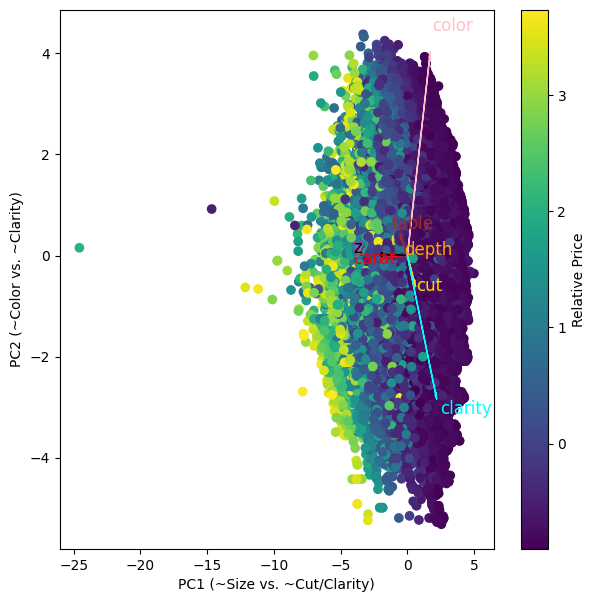

In [24]:
device = 'cpu'
n_epochs = 100
batch_size = 128
hidden_layer_size = 64

scaler = StandardScaler()
pca = PCA(n_components = 2)

input, price, df = prepare_data(fetch_data(), scaler)
x_train, x_test, y_train, y_test = split_data(input, price)
train_dataset = TableDataset(x_train, y_train)
test_dataset = TableDataset(x_test, y_test)

PCA_graph(input, price, pca)

criterion = nn.MSELoss(reduction='mean')

base_model = BaseModel().to(device)
base_optimizer = optim.Adam(base_model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(base_optimizer, step_size = 40, gamma = 0.25)

main_model = MainModel(hidden_size = hidden_layer_size).to(device)
main_optimizer = optim.Adam(main_model.parameters(), lr=0.01)
main_scheduler = optim.lr_scheduler.StepLR(main_optimizer, step_size = 40, gamma = 0.25)

dataloader_train = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dataloader_test = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [25]:
for epoch in range(n_epochs):
    train_loss, learning_rate = run_epoch(base_model, dataloader_train, base_optimizer, criterion, scheduler, is_train = True)
    #print(f'(Base Model) Epoch {epoch + 1} / {n_epochs}, Average loss per batch: {train_loss:.4f}, Learning_Rate: {learning_rate:.4f}')

In [26]:
for epoch in range(n_epochs):
    train_loss, learning_rate = run_epoch(main_model, dataloader_train, main_optimizer, criterion, main_scheduler, is_train = True)
    #print(f'(Main Model) Epoch {epoch + 1} / {n_epochs}, Average loss per batch: {train_loss:.4f}, Learning_Rate: {learning_rate:.4f}')

In [27]:
base_predictions = np.array([])
main_predictions = np.array([])
base_model.eval()
main_model.eval()
for i, (x, y) in enumerate(dataloader_test):
    x = x.to(device)
    y = y.to(device).unsqueeze(1)
    base_out = base_model(x)
    main_out = main_model(x)
    #error = criterion(base_out, y)
    #main_error = criterion(main_out, y)
    base_predictions = np.append(base_predictions, base_out.cpu().detach().numpy())
    main_predictions = np.append(main_predictions, main_out.cpu().detach().numpy())
    
base_predictions = (base_predictions * scaler.scale_[3]) + scaler.mean_[3]
main_predictions = (main_predictions * scaler.scale_[3]) + scaler.mean_[3]
prices = (y_test * scaler.scale_[3]) + scaler.mean_[3]

print(f'Base Model Metrics:\n')
print(f'\tpredictions: {np.round(base_predictions[:5], 2)}')
print(f'\tprices: {prices[:5]}\n')
print(f'\tR^2: {r2_score(prices, base_predictions)}')
print(f'\tRoot Mean Squared Error: {root_mean_squared_error(prices, base_predictions)}')
print(f'\tMean Absolute Error: {mean_absolute_error(prices, base_predictions)}')

print(f'\nMain Model Metrics:\n')
print(f'\tpredictions: {np.round(main_predictions[:5], 2)}')
print(f'\tprices: {prices[:5]}\n')
print(f'\tR^2: {r2_score(prices, main_predictions)}')
print(f'\tRoot Mean Squared Error: {root_mean_squared_error(prices, main_predictions)}')
print(f'\tMean Absolute Error: {mean_absolute_error(prices, main_predictions)}')

Base Model Metrics:

	predictions: [5593.15 5076.56 3787.89 3684.   5363.72]
	prices: [5728. 3558. 2797. 3734. 5077.]

	R^2: 0.9104417839148211
	Root Mean Squared Error: 1207.2455072970265
	Mean Absolute Error: 804.8179746399126

Main Model Metrics:

	predictions: [5600.38 4286.41 3100.34 3673.87 5019.84]
	prices: [5728. 3558. 2797. 3734. 5077.]

	R^2: 0.9809182140597652
	Root Mean Squared Error: 557.2529683648685
	Mean Absolute Error: 290.7926299355217


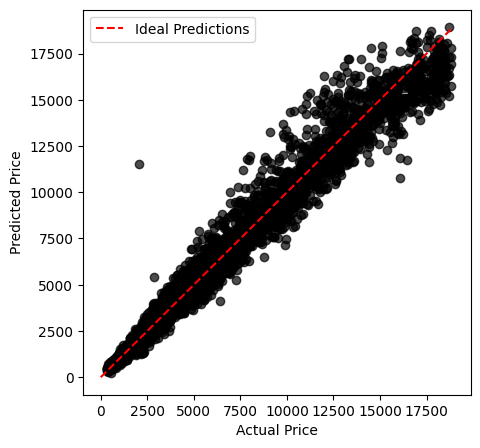

In [28]:
plt.figure(figsize = (5,5))
plt.plot([0, max(main_predictions)], [0, max(main_predictions)], color = 'red', linestyle = '--', label = 'Ideal Predictions')
plt.scatter(prices, np.clip(main_predictions, 0, None), alpha = 0.7, color = 'black')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()